# "Tell Me More" - Image Description Sequences

This notebook illustrates the image description sequence data from the "Tell Me More" paper. This data augments (a subset of) the ADE corpus with multi-sentence descriptive sentence. 

The sequences were elicited with the pretense that the recipient of the description asks "tell me more" after each sentence. (Hence, this is at least an imagined dialogue task...) This setting may or may not impose some sort of ordering on what is being described (from more general to more specific; or more salient to more general).

For a subset of the subset of ADE20k, this dataset also contains single sentence captions.

See <https://github.com/clp-research/image-description-sequences> and

* Nikolai Ilinykh, Sina Zarrieß, and David Schlangen. 2019. Tell me more: A dataset of visual scene description sequences. In Proceedings of the 12th International Conference on Natural Language Generation, pages 152–157, Tokyo, Japan. Association for Computational Linguistics


In [1]:
from __future__ import division
import codecs
import json
import configparser
import os
import sys

from collections import defaultdict, Counter

from time import localtime, strftime

import pandas as pd
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load config file, set up paths, make project-specific imports
config_path = os.environ.get('VISCONF')
if not config_path:
    # try default location, if not in environment
    default_path_to_config = '../../clp-vision/Config/default.cfg'
    if os.path.isfile(default_path_to_config):
        config_path = default_path_to_config

assert config_path is not None, 'You need to specify the path to the config file via environment variable VISCONF.'        

config = configparser.ConfigParser()
with open(config_path, 'r', encoding='utf-8') as f:
    config.read_file(f)

corpora_base = config.get('DEFAULT', 'corpora_base')
preproc_path = config.get('DSGV-PATHS', 'preproc_path')
dsgv_home = config.get('DSGV-PATHS', 'dsgv_home')

idsade_base = config.get('IDS-ADE', 'idsade_base')

sys.path.append(dsgv_home + '/Utils')
from utils import icorpus_code, plot_labelled_bb, get_image_filename, plot_img_ax, get_a_by_b, query_by_id

In [3]:
sys.path.append(dsgv_home + '/Utils')
from data_utils import load_dfs

df_names = [ 'ade_imgdf', 'ade_objdf', 'ade_reldf' ]

df = load_dfs(preproc_path, df_names)

## The ADE dataframes

(This is the same as in the ADE notebook.)

In [4]:
df['ade_imgdf'].head()

,i_corpus,image_id,image_cat,split,filename
0,6,1,a/airport_terminal,training,ADE_train_00000001.jpg
1,6,2,a/airport_terminal,training,ADE_train_00000002.jpg
2,6,3,a/art_gallery,training,ADE_train_00000003.jpg
3,6,4,b/badlands,training,ADE_train_00000004.jpg
4,6,5,b/ball_pit,training,ADE_train_00000005.jpg


In [5]:
df['ade_objdf'].head()

,i_corpus,image_id,region_id,level,label,synset,attr,occl,bb,image_cat,split,filename
0,6,1,1,0,wall,wall,glass,False,"[762, 810, 629, 127]",a/airport_terminal,training,ADE_train_00000001.jpg
1,6,1,2,0,wall,wall,glass,False,"[13, 580, 729, 301]",a/airport_terminal,training,ADE_train_00000001.jpg
2,6,1,3,0,wall,wall,glass,False,"[1415, 622, 631, 258]",a/airport_terminal,training,ADE_train_00000001.jpg
3,6,1,4,0,wall,wall,,False,"[2, 1012, 607, 457]",a/airport_terminal,training,ADE_train_00000001.jpg
4,6,1,5,0,wall,wall,,False,"[536, 1020, 517, 92]",a/airport_terminal,training,ADE_train_00000001.jpg


116 ('training', 'b/bathroom', 'ADE_train_00000116.jpg')


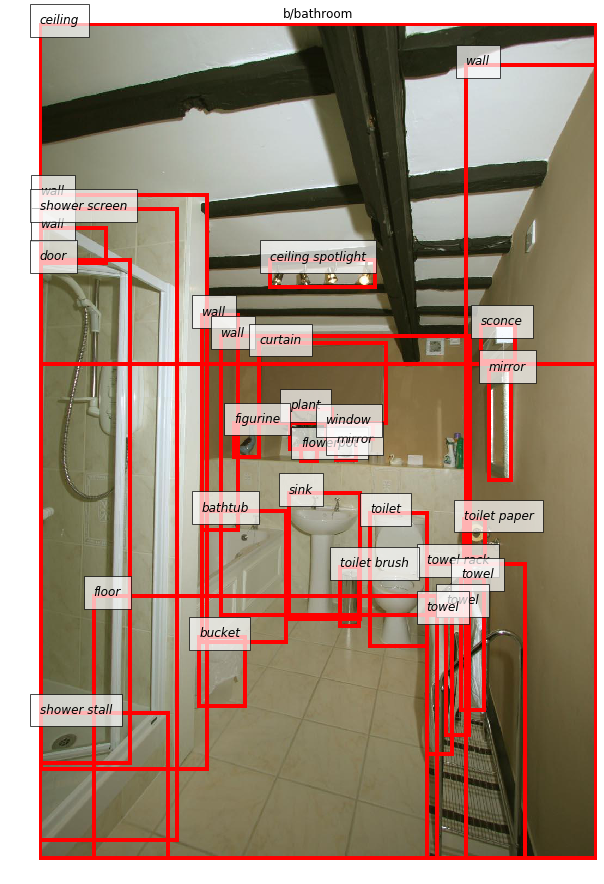

In [6]:
this_row = 115
ic, ii, cat, split, filename = df['ade_imgdf'].iloc[this_row][['i_corpus', 'image_id', 'image_cat', 'split', 'filename']]
full_ii = (split, cat, filename)
print(ii, full_ii)

bbs = df['ade_objdf'].query('(image_id == @ii) & (level == 0)')['bb label'.split()].values
#bbs = []

plot_labelled_bb(
    get_image_filename(config, ic, full_ii), bbs, title=cat
)

## The Image Description Sequences

In [7]:
idsade_base

'/Volumes/SSD_500/Corpora/External/ImageCorpora/TellMeMore-IDS'

In [8]:
tmm_df = pd.read_csv(idsade_base + '/sequences.csv', sep='\t')

In [9]:
tmm_df.head()

,Unnamed: 0,seq_id,image_id,image_path,image_cat,image_subcat,d1,d2,d3,d4,d5
0,0,0,6889,training/d/dining_room/ADE_train_00006889.jpg,dining_room,NaN,There is four chair red laquer dining set show...,There are opened white french doors leading to...,There is a pool with blue water showing throug...,The pools is surrounded by green shrubbery.,The wood floor is covered with white paint.
1,1,1,2489,training/b/basement/ADE_train_00002489.jpg,basement,NaN,basement,water heater,green tile,cinder block pillar,cement floor
2,2,2,13868,training/n/nursery/ADE_train_00013868.jpg,nursery,NaN,A child's bedroom.,With a desk.,A large stuffed polar bear on the bed.,Blue walls.,A red desk chair.
3,3,3,15412,training/p/playroom/ADE_train_00015412.jpg,playroom,NaN,There is a child's table set on the right.,"There is red, green, blue and yellow chair on ...",There is a gray colored microwave on the left.,There two plants on shelves on the left.,There is blue colored rug on the wooden floor.
4,4,4,5724,training/c/closet/ADE_train_00005724.jpg,closet,NaN,This is a bedroom,There are clothes on hangers in an open wardrobe,There is a rug with a circle on it,There is a stripy duvet,There are white drawers


In [10]:
this_image_row = 1455
ii, ic, da, db, dc, dd, de = tmm_df.iloc[this_image_row]['image_id image_cat d1 d2 d3 d4 d5'.split()]

None

None

None

The photo is a picture of a dining room with stairway rail in in the back.
There's a large doorway on the left that leads to the living room.
There's a large glass dining table with six brown leather chairs around it.
There's a chandelier with mini lamp shades hanging over the table.
There's a white fire place in the far back of the photo in the living room.


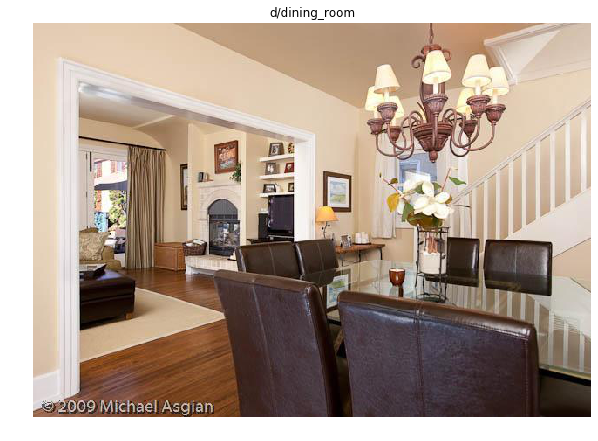

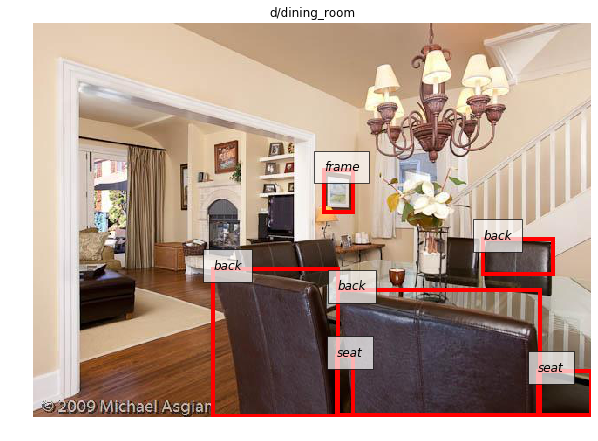

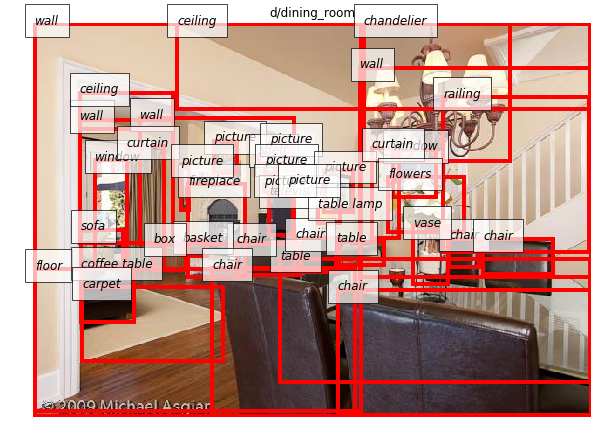

In [11]:
this_image_id = ii


ic, ii, cat, split, filename = df['ade_objdf'].query('(image_id == @this_image_id)').iloc[0][['i_corpus', 'image_id', 'image_cat', 'split', 'filename']]

full_ii = (split, cat, filename)

for level in list(range(3))[::-1]:
    bbs = df['ade_objdf'].query('(image_id == @this_image_id) & (level == @level)')['bb label'.split()].values
    display(
        plot_labelled_bb(
            get_image_filename(config, ic, full_ii), bbs, title=cat
        )
    )
    
for d in [da, db, dc, dd, de]:
    print(d)

### With Captions

In [12]:
adecap_df = pd.read_csv(idsade_base + '/captions.csv', sep='\t', usecols=range(1,4))

In [13]:
adecap_df.head()

,caption_id,image_id,caption
0,0,10717,An older style kitchen with top and bottom cup...
1,1,32,"A bathroom with lots of windows, to let in lot..."
2,2,5510,A blue and white nightstand next to a bed with...
3,3,10719,A huge bright kitchen with vaulted ceilings ov...
4,4,634,the image shows the inner part of a house kitc...


Caption: Clean neutral bathroom with sink, toilet, clawfoot bathtub, and gauzy white curtains.

Image Description Sequence:
  this is a bathroom
  there is a bathtub
  ther eis a bathroom sink across the bathtub and the toilet is next to the bathtub
  there are white towels hanging
  there are two photos on top of the towel


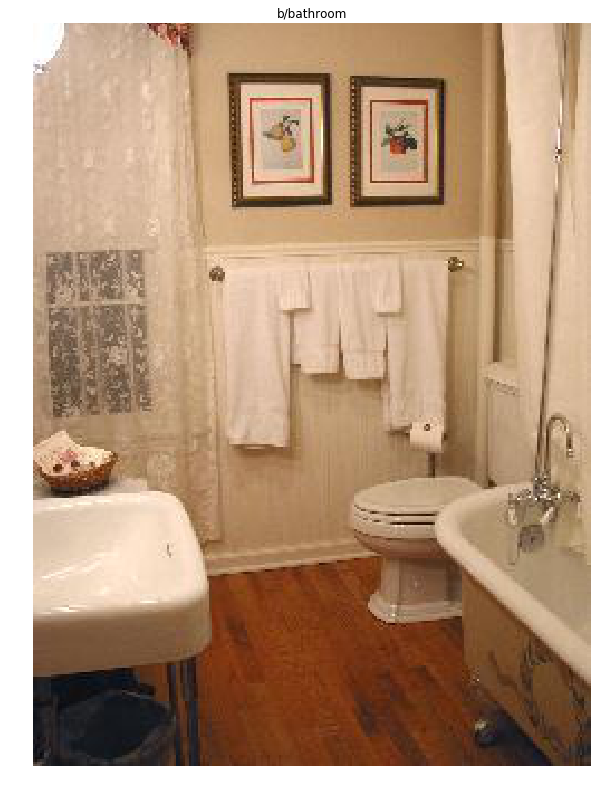

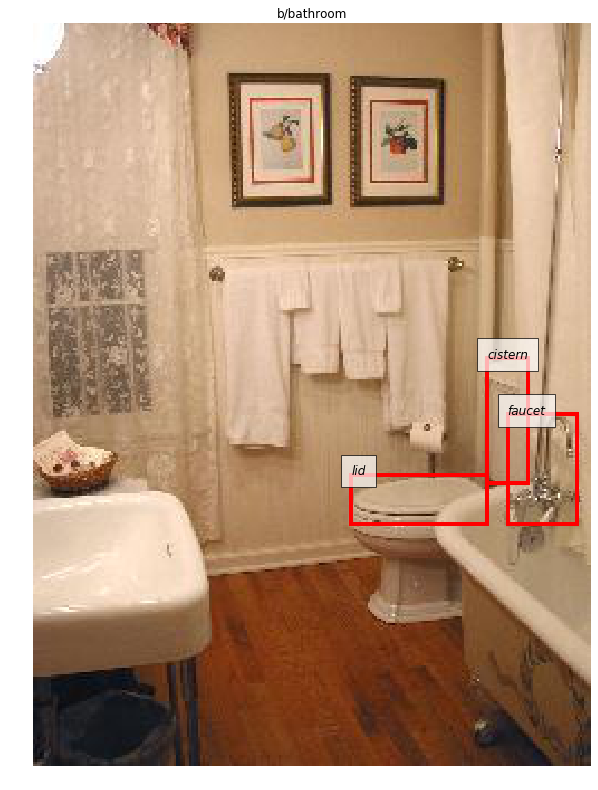

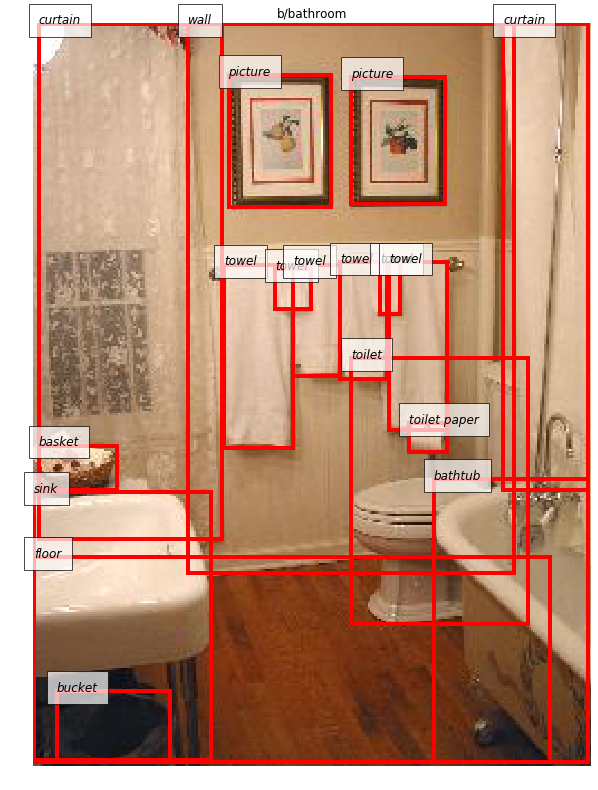

In [14]:
this_image_row = 16

#ci, ii, cap = adecap_df[adecap_df['image_id'] < 100000].iloc[this_image_row]
ci, ii, cap = adecap_df.iloc[this_image_row]
split = 'training'
if ii > 100000:
    split = 'validation' 
    ii = ii - 100000

#ic, da, db, dc, dd, de = tmm_df[tmm_df['image_id'] == ii]['image_cat d1 d2 d3 d4 d5'.split()]
ic, da, db, dc, dd, de = tmm_df[tmm_df['image_id'] == ii]['image_cat d1 d2 d3 d4 d5'.split()].iloc[0]

this_image_id = ii


ic, ii, cat, split, filename = df['ade_objdf'].query('(image_id == @this_image_id)').iloc[0][['i_corpus', 'image_id', 'image_cat', 'split', 'filename']]

full_ii = (split, cat, filename)

for level in list(range(3))[::-1]:
    bbs = df['ade_objdf'].query('(image_id == @this_image_id) & (level == @level)')['bb label'.split()].values
    display(
        _ = plot_labelled_bb(
            get_image_filename(config, ic, full_ii), bbs, title=cat
        )
    )
    
print('Caption:', cap)
print()
print('Image Description Sequence:')
for d in [da, db, dc, dd, de]:
    print(' ', d)